
**Dataset Pre-Processing**
---



For initial exploratory data analysis, we are exploring the Quality of Government dataset compiled by the University of Goethenburg. This dataset consists of 19 thematic groupings relating to country characteristics, with 260 unique variables and a range from 1946-2021. The dataset is available for non-commercial public use. 
  
*Dahlberg, Stefan,  Aksel Sundström, Sören Holmberg, Bo Rothstein, Natalia Alvarado Pachon & Cem Mert Dalli*. 2021. The Quality of Government Basic Dataset, version Jan21. University of Gothenburg: The Quality of Government Institute, http://www.qog.pol.gu.se doi:10.18157/qogbasjan21

In [ ]:
#Install initial dependencies
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip show pandas-profiling
!pip install shap
!pip install firebase_admin

In [ ]:
#Load dependencies
import numpy as np, pandas as pd, seaborn as sns
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import firebase_admin
from firebase_admin import firestore, credentials
%matplotlib inline



In [ ]:
#Connect to database
cred = credentials.Certificate("/content/burnished-yeti-321014-767857513ba4.json")
firebase_admin.initialize_app(cred)
db = firestore.client()


In [ ]:
#Connect to collection and query for rows from year 2000 onward
doc_qog = db.collection('QoG').where('year','>=',2000)

#Read documents into dataframe
qog_docs = [snapshot for snapshot in doc_qog.stream()]
QoG_dict = list(map(lambda x: x.to_dict(), qog_docs))
qog = pd.DataFrame(QoG_dict)

#Describe dataframe
print(qog.shape)
qog.head(5)

(4431, 1864)


,bti_ba,prp_std,cpds_vall,gpi_conf,sgi_go,gcb_putil,bti_lod,eu_empy1524t,lp_protmg80,gea_ea1524m,eu_sctlkisf,wef_wi,bti_ffe,sw_cll,wdi_debt,eu_sctcltclmt,aid_cpnc,jw_avgvote,oecd_ptempl_t1,eu_demcnmigratn,wgov_totfem,wwbi_fmwrpumean,eu_resbust,eu_resgovf,cpds_vnl,vdem_exthftps,ideaesd_lsvm,ictd_taxexsc,oecd_pension_t1a,oecd_totaltax_t1,oecd_housnonfin_t1a,oecd_fdindex_t1c,oecd_nurse_g3,iaep_rmcc,gpi_jail,eu_trfrldnld,gwf_duration,iaep_enlc,gea_ea2534f,kun_polrel,...,oecd_airqty_t1,ihme_hle_0104f,gpi_ss,gle_imp,eu_heanursp,eu_edued303458t,aii_q24,ihme_lifexp_0104f,wdi_idpvc,aii_q47,wr_nonautocracy,oecd_migunemp_t1f,eu_sctlkisothf,oecd_gengovdistri_t1f,ccp_market,iiag_inf,eu_unempytott,vdem_corr,who_matmort,wdi_birthregr,aii_aio,fao_luforreg,wdi_homicides,iiag_pri,wdi_nerpr,oecd_selfempl_t1a,gggi_ggi,wdi_death,eu_sctsf,bti_poa,aii_q21,oecd_fdindex_t1d,oecd_socexpnd_t1b,wdi_agrland,wwbi_psepemp,wdi_incsh10h,eu_sctdfm,oecd_tiva_inter_t1e,oecd_svctrade_t2,wdi_empind
0,NaN,0.785092,0.0,NaN,NaN,NaN,NaN,NaN,0.9,12.96,NaN,NaN,NaN,0.0,100.460883,NaN,124.0,1.375000,15.94715,NaN,1.0,NaN,NaN,NaN,0.0,2.461,480.0,16.758400,7.291169,25.777,15924.389,NaN,56.48,1.0,NaN,NaN,NaN,0.0,13.59,1.262166,...,1124.7,72.173378,NaN,477609.94000,NaN,NaN,NaN,84.141663,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,0.095,9.0,NaN,NaN,58.470001,0.531664,NaN,NaN,18.33397,NaN,7.700,NaN,NaN,NaN,NaN,3.504,NaN,NaN,NaN,NaN,13.47,118.2412,31.419001
1,NaN,0.689219,NaN,NaN,NaN,NaN,NaN,NaN,4.8,8.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,3.0,NaN,NaN,NaN,NaN,-0.766,NaN,12.056909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6.97,-0.401754,...,255.4,60.667088,NaN,62067.59000,NaN,NaN,NaN,70.371399,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,0.788,272.0,NaN,NaN,96.199997,1.042012,NaN,NaN,NaN,NaN,7.475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.4,NaN,38.82,NaN,17.434000
2,NaN,1.254967,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.096386,NaN,NaN,3.0,NaN,NaN,NaN,NaN,-0.761,NaN,6.094576,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,0.88,-0.261979,...,NaN,49.148220,NaN,535.96002,NaN,NaN,NaN,56.679401,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,0.635,813.0,NaN,NaN,94.500000,NaN,NaN,26.89543,NaN,NaN,17.234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.597000
3,NaN,1.201079,NaN,NaN,NaN,NaN,NaN,NaN,21.4,8.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,6.0,NaN,NaN,NaN,NaN,-1.417,150.0,25.038029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,0.0,7.71,-1.092045,...,NaN,44.228897,NaN,2026.37000,NaN,NaN,NaN,50.725620,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,0.844,579.0,NaN,NaN,99.349998,NaN,NaN,89.50339,NaN,NaN,16.534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.547000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.6,4.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,-2.471,NaN,8.501144,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.0,0.0,2.73,-1.090604,...,NaN,51.295361,NaN,1595.59000,NaN,NaN,NaN,60.810169,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,0.917,894.0,NaN,NaN,99.879997,NaN,NaN,NaN,NaN,NaN,14.973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.306000


More detailed descriptions of the variables can be found in the QoG codebook (https://www.qogdata.pol.gu.se/data/codebook_bas_jan21.pdf), but for our instances we are going to explore the data as is. From the above, you can see we have 15825 instances and 1864 variables, which is a considerably large dataset. To reduce dimensionality, we will only be concerned with 2000 onwards. This is theoretically justified, because we want to visualize a snapshot of influence in the last 22 years. Earlier data, while important, features greater variability as the result of regime changes, shifts in power, and technological advances that cannot be accurately accounted for. We are only concerned with a subset of variables concerned with conflict, history, and migration for our model. 

In [ ]:
var_list = ['cname', 'year', 'ccodecow','ajr_settmort','atop_consult','atop_defensive','atop_neutrality','atop_nonagg','atop_number','atop_offensive','bicc_gmi','bicc_hw','bicc_milexp','bicc_mileper','bmr_demdur','bti_ci','bti_cst','bti_muf','eu_demcnmigratn','eu_imm118t','eu_imm118f','eu_imm118m','eu_imm1824f','eu_imm1824m','eu_imm1824t','eu_imm2534f','eu_imm2534m','eu_imm2534t','eu_imm3564f','eu_imm3564m','eu_imm3564t','eu_imm65f','eu_imm65m','eu_imm65t','ffp_ext','ffp_gg','ffp_hf','ffp_ref','ffp_sec','gcb_pmil','gd_ptsa','gd_ptsh','gd_ptss','gfs_def','gpi_conf','gpi_dic','gpi_mil','gtr_centaxdir1900','gtr_centaxgdp1900','gtr_centaxind1900','gtr_centaxtot1850','gtr_centaxtot1900','ht_colonial','iaep_epmf','iaep_milo','icd_infcapirt1750','icd_infcapirt1800','icd_infcapirt1850','icd_infcapirt1900','mad_gdppc1900','nelda_rpae','nelda_vcdbe','oecd_gengovdistri_t1b','oecd_migforpop_t1a','oecd_migforpop_t1b','oecd_netmigr_t1a','oecd_netmigr_t1b','oecd_netmigr_t1c','oecd_netmigr_t1d','oecd_netmigr_t1e','oecd_netmigr_t1f','oecd_netmigr_t1g','r_atlas','r_elf61','r_elf85','r_muller','r_roberts','svs_ind','ucdp_type2','ucdp_type3','ucdp_type4','voh_gti','wbgi_pve','wbgi_pvn','wbgi_pvs','wdi_afp','wdi_afpt','wdi_armexp','wdi_armimp','wdi_brdeath','wdi_expmil','wdi_expmilge','wdi_idpdis','wdi_idpvc','wdi_idpvp','wdi_imig','wdi_migration','wdi_peacekeep','wdi_refasy','wdi_refori',
            'wgov_minmil','wgov_totmil','wvs_confaf','wvs_fight','wvs_psarmy']
qog = qog[qog.columns[np.where(qog.columns.isin(var_list))]]
qog.rename(columns = {'ccodecow':'COWcode', 'cname':'country_name'}, inplace = True)

**Digital Society Project** 

The Digital Society Project (DSP) features data from a global survey of country and area experts. It contains features corresponding to 35 indicators, with topics relating to online censorship, polarization and politicization of social media, misinformation campaigns, coordinated information operations, foreign influence in and monitoring of domestic politics, and more. 
 

In [ ]:
#Connect to collection
dsp = db.collection('DSP')

#Query dates past 2000, stream to dict of dicts, create dataframe
dsp_doc = dsp.where('year','>=',2000).stream()
dsp_dict = list(map(lambda x:x.to_dict(),dsp_doc))
dsp = pd.DataFrame(dsp_dict)

In [ ]:
df = dsp.merge(qog, how = 'inner', on = ['COWcode', 'year', 'country_name'])
df.drop(columns = df.columns[4:20], inplace = True)
df.drop(columns = ['country_text_id', 'country_id'], inplace = True)
print(df.shape)
df.head()

(3286, 556)


,v2smgovsmalt_osp,v2smonper_osp_sd,v2smgovfilprc_osp_sd,v2smcamp_osp_codehigh,historical,v2smpardom_ord,v2smlawpr_osp_sd,v2smregcon_osp_codelow,v2smprivcon,v2smhargr_8,v2smarrest_ord_codehigh,v2smgovfilprc_nr,v2smonper_mean,v2smprivex_codehigh,v2smorgavgact_mean,v2smgovsmalt_osp_codelow,v2smforads_ord,v2smregapp,v2smcamp_codelow,v2smgovsmalt_ord_codehigh,v2smregcap_sd,v2smgovsmmon_nr,v2smgovsmmon_mean,v2smregcon_codelow,v2smorgviol_codelow,v2smprivcon_mean,v2smregcon_mean,codingend_contemp,v2smgovfilcap_osp_codehigh,gapstart1,gapstart3,v2smcamp_osp_codelow,v2smgovsmcenprc_osp_codehigh,v2smgovab_ord,v2smpolhate_ord_codehigh,v2smgovsmmon_osp_sd,v2smparab_osp_codelow,v2smgovsmcenprc_mean,v2smgovfilcap_osp_sd,v2smgovshut_codehigh,...,nelda_rpae,wvs_confaf,bicc_hw,wdi_armexp,ffp_ext,wdi_brdeath,ajr_settmort,atop_neutrality,gtr_centaxgdp1900,gcb_pmil,wdi_idpdis,eu_imm118f,eu_imm118t,gd_ptsa,atop_consult,wdi_imig,eu_imm2534f,oecd_netmigr_t1a,icd_infcapirt1900,r_elf61,iaep_milo,ucdp_type4,nelda_vcdbe,eu_imm1824m,wdi_expmil,ffp_gg,ffp_sec,wbgi_pvs,eu_imm1824f,oecd_netmigr_t1f,ffp_hf,bti_muf,ht_colonial,wvs_psarmy,atop_nonagg,gpi_mil,eu_imm1824t,oecd_netmigr_t1e,oecd_gengovdistri_t1b,wdi_idpvc
0,1.837,0.262,0.395,2.314,0,3,0.347,0.608,-2.220,0.250,1,4,3.000,-0.863,2.500,1.350,3,-0.456,-1.150,2,0.501,4,1.500,-2.320,-0.702,0.000,1.50,2020,2.014,NaN,NaN,1.772,3.200,3,3,0.361,2.651,2.75,0.464,0.961,...,NaN,NaN,1.15,NaN,NaN,NaN,5.63479,0.0,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.115717,NaN,NaN,NaN,0.341,1.0,NaN,NaN,NaN,2.928005,NaN,NaN,0.455642,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,2.472,0.347,0.246,1.446,0,2,0.399,1.195,-1.532,0.750,1,8,1.571,-0.371,1.250,2.242,3,-0.710,-2.746,3,0.623,7,2.000,-1.685,-1.438,1.333,1.75,2020,2.030,NaN,NaN,0.657,2.406,1,1,0.238,2.010,2.00,0.336,-1.087,...,NaN,NaN,0.04,NaN,NaN,268.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,4.0,0.0,3.023992,NaN,NaN,0.000000,0.699,0.0,NaN,NaN,NaN,0.962150,NaN,NaN,0.455642,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,1.684,0.429,0.341,0.555,0,3,0.407,1.360,-0.548,0.000,1,4,1.333,-0.581,0.500,1.411,2,-1.532,-4.021,2,0.771,4,2.500,-1.588,0.169,4.000,2.75,2020,0.662,NaN,NaN,0.035,2.812,3,3,0.293,1.053,2.75,0.305,-0.569,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,5.696161,NaN,NaN,NaN,0.680,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.455642,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.521,0.440,0.326,2.334,0,2,0.461,2.765,0.804,0.400,1,5,2.667,-0.235,1.200,1.112,3,0.074,-1.389,2,0.526,5,2.200,-0.014,-0.475,3.500,3.20,2020,1.909,NaN,NaN,1.576,3.069,2,2,0.302,2.037,2.60,0.272,-0.772,...,NaN,NaN,0.64,NaN,NaN,989.0,5.63479,0.0,NaN,NaN,NaN,NaN,NaN,3.0,0.0,1.256394,NaN,NaN,NaN,0.851,0.0,NaN,NaN,NaN,1.362045,NaN,NaN,0.455642,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,3.756,0.250,0.235,2.334,0,4,0.278,3.806,2.097,0.125,3,8,3.250,1.056,1.875,3.652,4,0.119,-1.027,4,0.581,8,3.625,1.247,0.103,4.000,3.75,2020,2.580,NaN,NaN,1.842,4.000,4,4,0.219,3.560,4.00,0.357,1.053,...,NaN,NaN,1.44,NaN,NaN,NaN,NaN,0.0,4.710904,NaN,NaN,NaN,NaN,1.0,1.0,6.338175,NaN,4953.703,0.503491,0.006,0.0,NaN,NaN,NaN,1.862356,NaN,NaN,0.313570,NaN,150.029,NaN,NaN,0.0,NaN,1.0,NaN,NaN,62.0,NaN,NaN


**Adding Our Target Variable**





Here we are using the Correlates of War Project's National Material Capabilities dataset to forumlate our target variable. Because we are trying to identify factors that contribute to a country's level of influence, we need a historical target variable that is indicative of past "power." CoW National Material Capabilities dataset asserts there are six indicators that explain power (military expenditure, military personnel, energy consumption, iron and steel production, urban population, and total population). We will expand upon these variables with our dataset, but the Composite Index of National Capability will give us a reasonable estimate of power/influence over the last 25 years. This index will allow us to identify which variables have explanatory power. 

As an aside, you will see further below that the CINC variable would do well with a log transformation. However, in boosting and random forest models, the shrunken variance causes the tree to make less balanced splits. The non-transformed variable will be affected more by the higher values. Because we're interested in the relative capacity/power of a country (and by extension, which countries are most capable), we should be concerned with the accuracy of the model for higher scoring countries. 

In [ ]:
#Changing descriptive variables to Object Type
for i in ['country_name', 'year', 'COWcode']:
  df[i] = df[i].astype('O')

#drop descriptive columns
df.drop(columns = ['codingend_hist','codingstart','gapstart2',
                   'gapend3','gapend1','codingend','gapstart1','historical','codingend_contemp',
                   'historical_date','gapend2','gap_index'], inplace = True)

#Create dataset for testing new values of CINC scores(which doesn't provide information beyond 2016)
pred_df = df.reset_index()[df.year>2016]

# CONNECT to CINC collection
cinc = db.collection('cinc')

#Same as above, query, dict, pandas 
cinc_docs = cinc.stream()
cinc_dict = list(map(lambda x: x.to_dict(), cinc_docs))
target = pd.DataFrame(cinc_dict)

#Drop irrelevant columns and merge with total dataframe
target.drop(columns = ['stateabb', 'milex', 'milper', 'irst', 'pec', 'tpop', 'upop', 'version'], inplace = True)
target.rename(columns = {'ccode':'COWcode'}, inplace = True)
df = df.merge(target, 'inner', on = ['COWcode', 'year'])

print(len(df.country_name.unique()), ' total countries represented')

#set index
pred_df.set_index(['country_name','year','COWcode'],inplace = True)
df.set_index(['country_name','year','COWcode'], inplace = True)

#Show null values and updated dataframe 
print('Total Null Values:',df.isna().sum().sum())
df.head()


157  total countries represented
Total Null Values: 162784


,,,v2smgovsmalt_osp,v2smonper_osp_sd,v2smgovfilprc_osp_sd,v2smcamp_osp_codehigh,v2smpardom_ord,v2smlawpr_osp_sd,v2smregcon_osp_codelow,v2smprivcon,v2smhargr_8,v2smarrest_ord_codehigh,v2smgovfilprc_nr,v2smonper_mean,v2smprivex_codehigh,v2smorgavgact_mean,v2smgovsmalt_osp_codelow,v2smforads_ord,v2smregapp,v2smcamp_codelow,v2smgovsmalt_ord_codehigh,v2smregcap_sd,v2smgovsmmon_nr,v2smgovsmmon_mean,v2smregcon_codelow,v2smorgviol_codelow,v2smprivcon_mean,v2smregcon_mean,v2smgovfilcap_osp_codehigh,gapstart3,v2smcamp_osp_codelow,v2smgovsmcenprc_osp_codehigh,v2smgovab_ord,v2smpolhate_ord_codehigh,v2smgovsmmon_osp_sd,v2smparab_osp_codelow,v2smgovsmcenprc_mean,v2smgovfilcap_osp_sd,v2smgovshut_codehigh,v2smorgviol_ord,v2smregcap_codelow,v2smprivex_osp_sd,...,wvs_confaf,bicc_hw,wdi_armexp,ffp_ext,wdi_brdeath,ajr_settmort,atop_neutrality,gtr_centaxgdp1900,gcb_pmil,wdi_idpdis,eu_imm118f,eu_imm118t,gd_ptsa,atop_consult,wdi_imig,eu_imm2534f,oecd_netmigr_t1a,icd_infcapirt1900,r_elf61,iaep_milo,ucdp_type4,nelda_vcdbe,eu_imm1824m,wdi_expmil,ffp_gg,ffp_sec,wbgi_pvs,eu_imm1824f,oecd_netmigr_t1f,ffp_hf,bti_muf,ht_colonial,wvs_psarmy,atop_nonagg,gpi_mil,eu_imm1824t,oecd_netmigr_t1e,oecd_gengovdistri_t1b,wdi_idpvc,cinc
country_name,year,COWcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Mauritania,2000,435.0,1.837,0.262,0.395,2.314,3,0.347,0.608,-2.220,0.250,1,4,3.000,-0.863,2.500,1.350,3,-0.456,-1.150,2,0.501,4,1.500,-2.320,-0.702,0.000,1.50,2.014,NaN,1.772,3.200,3,3,0.361,2.651,2.75,0.464,0.961,1,-0.870,0.178,...,NaN,1.15,NaN,NaN,NaN,5.63479,0.0,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.115717,NaN,NaN,NaN,0.341,1.0,NaN,NaN,NaN,2.928005,NaN,NaN,0.455642,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.000256
Nepal,2000,790.0,2.472,0.347,0.246,1.446,2,0.399,1.195,-1.532,0.750,1,8,1.571,-0.371,1.250,2.242,3,-0.710,-2.746,3,0.623,7,2.000,-1.685,-1.438,1.333,1.75,2.030,NaN,0.657,2.406,1,1,0.238,2.010,2.00,0.336,-1.087,1,-1.498,0.181,...,NaN,0.04,NaN,NaN,268.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,4.0,0.0,3.023992,NaN,NaN,0.000000,0.699,0.0,NaN,NaN,NaN,0.962150,NaN,NaN,0.455642,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.001276
Bhutan,2000,760.0,1.684,0.429,0.341,0.555,3,0.407,1.360,-0.548,0.000,1,4,1.333,-0.581,0.500,1.411,2,-1.532,-4.021,2,0.771,4,2.500,-1.588,0.169,4.000,2.75,0.662,NaN,0.035,2.812,3,3,0.293,1.053,2.75,0.305,-0.569,2,-3.209,0.182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,5.696161,NaN,NaN,NaN,0.680,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.455642,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000125
Chad,2000,483.0,1.521,0.440,0.326,2.334,2,0.461,2.765,0.804,0.400,1,5,2.667,-0.235,1.200,1.112,3,0.074,-1.389,2,0.526,5,2.200,-0.014,-0.475,3.500,3.20,1.909,NaN,1.576,3.069,2,2,0.302,2.037,2.60,0.272,-0.772,1,-1.058,0.203,...,NaN,0.64,NaN,NaN,989.0,5.63479,0.0,NaN,NaN,NaN,NaN,NaN,3.0,0.0,1.256394,NaN,NaN,NaN,0.851,0.0,NaN,NaN,NaN,1.362045,NaN,NaN,0.455642,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.000578
Portugal,2000,235.0,3.756,0.250,0.235,2.334,4,0.278,3.806,2.097,0.125,3,8,3.250,1.056,1.875,3.652,4,0.119,-1.027,4,0.581,8,3.625,1.247,0.103,4.000,3.75,2.580,NaN,1.842,4.000,4,4,0.219,3.560,4.00,0.357,1.053,2,1.246,0.119,...,NaN,1.44,NaN,NaN,NaN,NaN,0.0,4.710904,NaN,NaN,NaN,NaN,1.0,1.0,6.338175,NaN,4953.703,0.503491,0.006,0.0,NaN,NaN,NaN,1.862356,NaN,NaN,0.313570,NaN,150.029,NaN,NaN,0.0,NaN,1.0,NaN,NaN,62.0,NaN,NaN,0.001782


**NOTE:** The target variable dataset's period ends in 2016. Thus, I am leaving performing an inner merge to bring the original dataframe to {2000-2016} for exploratative purposes. For the future we can set up a Bayesian imputation perhaps for imputing current power values. 

In [ ]:
#Creating qog only dataset for modelling variants
qog.rename(columns = {'ccodecow':'COWcode', 'cname':'country_name'}, inplace = True)
qog_df = qog.merge(target, on = ['COWcode', 'year'], how = 'inner')

# XGBoost


**Background**

XGBoost is an award winning algorithm/library that is built upon optimized distributed gradient boosting. That may be a lot of jargon, so let's break it down into the core components: 


*   **Gradient Descent**
        A method to minimize a function with several to many variables, it works by minimizing the cost function of a model, or the measure of how close the predicted values are to the actual. It is an iterative approach that updates the model's weights/parameters in order to minimize the cost and returns the best weights. 
*   **Gradient Boosting**
        This is a machine learning technique that consolodates weak prediction models into a single, strong prediction model (these are usually decision trees). Gradient Boosted Models use the descent optimization to return optimal parameters, but the result is the addition of multiple functions. 

**Characteristics of XGBoost** 

How does this serve our purposes of identifying variables that contribute to a country's power? Our dataset as is contains many missing variables and features high multicollinearity between variables, how do we deal with that? Here lies the beauty of XGBoost: In tree algorithms, the branches learn to deal with missing values through training. Linear boosters treat missing values as zeros. In addition, decision trees are naturally resistant to multicollinear variables because their variable choice is based on the incremental gain that it presents to the model. If two variables are highly correlated, the tree will choose the variable with the largest model gain (and thus minimizing the cost function). This is why we are not cleaning the data further at this stage. 

**Initial Steps** 

XGBoost utilizes a data matrix, which is optimized for memory efficiency and training speed. We're going to split this matrix into a training dataset, and a test and validation set so that we can measure the efficiency of our collection of decision trees. 



In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, explained_variance_score
import numpy as np


X,y = df.iloc[:,:-1], df.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data = X, label = y)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 123)

print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

1696 train examples
424 validation examples
530 test examples


We have 1696 instances for training with 424 validation examples and 530 test examples. Next we are going to train our boosted regression model (as our target variable is currently continuous), optimized for minimizing squared error. Our initial parameters have a max depth of 6 branches, and contains 50 estimators.

In [ ]:
clf = xgb.XGBRegressor(objective = 'reg:squarederror', max_depth = 6, n_estimators=50)
clf = clf.fit(X_train, y_train, verbose=11)
y_pred = clf.predict(X_test)
print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

RMSE: 0.0030


The root mean squared error of our model is .003, how do we determine if this a good model? First let's observe the descriptive statistics of the target variable. As you can see below, the majority of the target variable is centered on 0, and heavily right skewed. This makes perfect sense, as there are few countries that share a significant portion of influence and the majority being dependent on the few. The standard deviation of the target variable is ~ .0176. The RMSE tells us the standard deviation of the explained variance, or more simply, the average error is ± .003 from the actual value. This seems to indicate that the model is predictive for more powerful countries, but not as much for the less powerful. 

count    2650.000000
mean        0.004931
std         0.017617
min         0.000003
25%         0.000349
50%         0.000987
75%         0.003137
max         0.231185
Name: cinc, dtype: float64


(0.0, 100.0)

<Figure size 432x288 with 0 Axes>

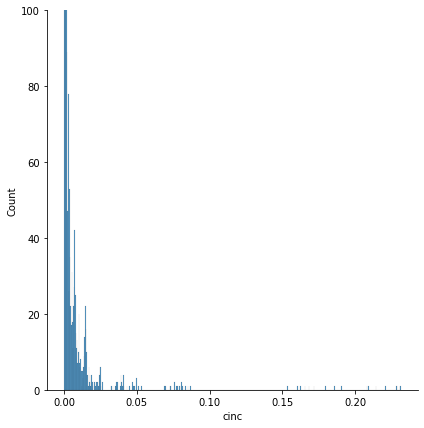

In [ ]:
print(df.cinc.describe())
plt.clf()
sns.displot(df.cinc, height = 6)
plt.ylim(0,100)


In [ ]:
print("The model explains {:.3f}% of the variance.".format(100*explained_variance_score(y_test, y_pred)))
print("Number of trees in model: {:}".format(len(clf.get_booster().get_dump())))

The model explains 99.604% of the variance.
Number of trees in model: 50


Our model seems to be highly predictive, explaining 99.765% of the variance. As a reminder, XGBoost and Gradient Boosting uses an amalgamation of decision trees to form their model. Ours happens to have a total of 100 trees, where the predicted CINC value is represented by a summation of tree output. An example of one of these trees is below for you to visualize what the structure of a tree *could* look like. 

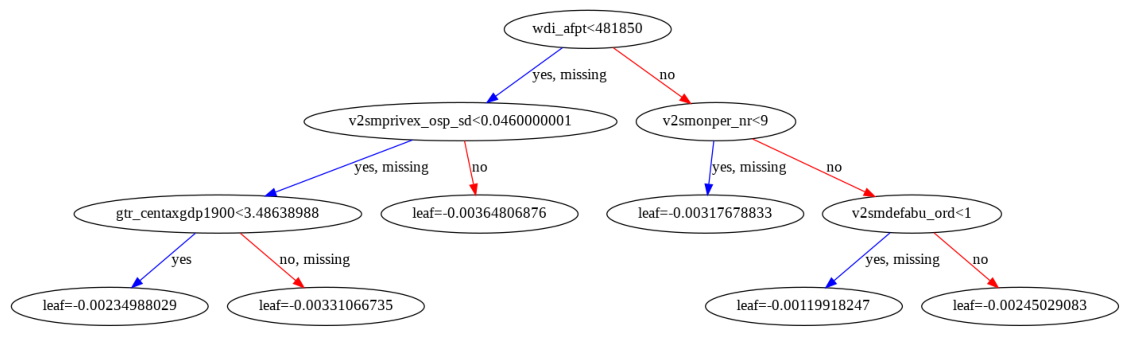

In [ ]:
ax = xgb.plot_tree(clf, num_trees=25) 
fig = ax.figure
fig.set_size_inches(20, 10)


This is a great visualization, but it doesn't tell us much about which factors are most significant in predicting CINC scores. For that, we will turn to the SHAP library, which is a game-theoretic approach meant to analyze the output of a machine learning model. It uses Shapley values that sum up to the difference between the outcomes when all factors are present and when no factors are present. 

In [ ]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap_values

array([[-2.67946660e-07, -7.39229336e-06,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -4.98089139e-06],
       [ 5.55085262e-06,  1.49206535e-05,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -1.77710399e-06],
       [-4.98121040e-07, -8.05428408e-06,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -1.45608897e-06],
       ...,
       [-2.67946660e-07, -5.91234448e-06,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -1.28355578e-06],
       [-2.67946660e-07,  1.10916471e-05,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  4.82148789e-06],
       [-4.98121040e-07,  3.81675891e-05,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -4.52570021e-07]], dtype=float32)

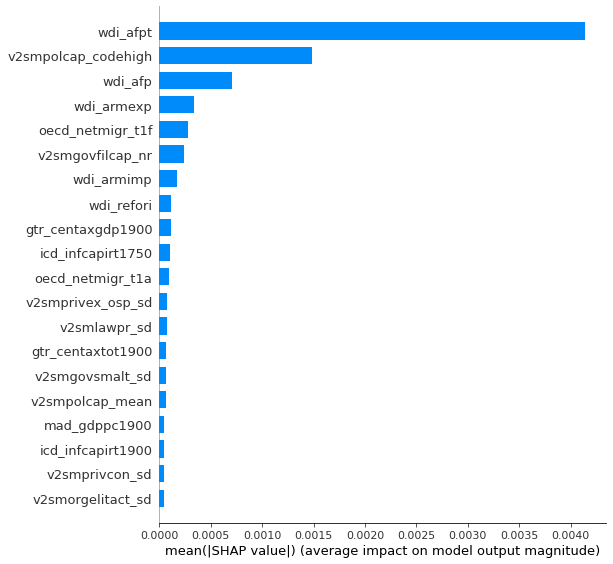

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

From the SHAP analysis, the most significant factors relate to the total armed forces personnel, government internet filtering in practice, armed forces personnel as a percentage of total labor force, arms exports and imports, government dissemination of false information domestically, among others. Please consult the respective codebooks for more information on relevant factors.

# Playing with XGBoost Params


Something that we must consider is whether we have the most optimal model parameters. In order to test multiple parameters at once, we'll use sklearn's package GridSearchCV. This is a cross-validation approach that searches over specified parameters of a an estimator. 

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.07, .1,.12], #so called `eta` value
              'max_depth': [5,6,7],
              'min_child_weight': [1],
              'silent': [0,1],
              'subsample': [0.7,1],
              'colsample_bytree': [0.7,1],
              'n_estimators': [50,100,500]}

xgb_grid = GridSearchCV(clf,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)
   

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   59.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  8.5min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 19.0min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 38.4min
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed: 55.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=6,
                                    min_child_weight=1, missing=None,
                                    n_estimators=50, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0...
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=5,
             param_grid={'colsample_bytree': [0.7, 1],
                         'learning_rate': [0.07, 0.1, 0.12],
                         'max_depth': [5, 6, 7], 'min_child_weight': [1],
                         'n_esti

In [ ]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.9947100760004132
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 0, 'subsample': 1}


In [ ]:
#Implement new parameters
model = xgb.XGBRegressor(parameters = xgb_grid.best_params_)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("The model explains {:.3f}% of the variance.".format(100*explained_variance_score(y_test, y_pred)))
print("Number of trees in model: {:}".format(len(model.get_booster().get_dump())))

[17:41:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.0015
The model explains 99.470% of the variance.
Number of trees in model: 100


The model slightly beats out the prior model, with a RMSE of .0015 and explained variance of 99.5%. Let's predict a new CINC score for all countries on years past 2016. 

In [ ]:
#predict the new values for 2017-2020
pred_df = pred_df.reset_index()
pred_df['labels'] = model.predict(pred_df.iloc[:,4:])
predictions = pred_df[['country_name', 'year','COWcode','labels']]

#create dataframe with country average CINC values over 18 year timeframe
avgs = df.groupby('country_name', as_index=True)['cinc'].mean()
predictions = predictions.merge(avgs, on = 'country_name')

#calculate the difference between predicted values and the average by country
predictions['Delta'] = abs(predictions.labels-predictions.cinc)
predictions.rename(columns = {'cinc':'Avg. CINC'}, inplace = True)

In [ ]:
print('Average discrepancy between average values and predicted {:.3f}'.format(predictions['Delta'].mean()))
print(predictions.tail(10))

Average discrepancy between average values and predicted 0.002
    country_name  year  COWcode    labels  Avg. CINC     Delta
618   Tajikistan  2019    702.0  0.000624   0.000371  0.000253
619   Tajikistan  2020    702.0  0.000622   0.000371  0.000251
620    Indonesia  2017    850.0  0.017589   0.014750  0.002839
621    Indonesia  2018    850.0  0.015758   0.014750  0.001008
622    Indonesia  2019    850.0  0.001479   0.014750  0.013272
623    Indonesia  2020    850.0  0.000637   0.014750  0.014113
624      Ecuador  2017    130.0  0.002122   0.001525  0.000597
625      Ecuador  2018    130.0  0.002257   0.001525  0.000732
626      Ecuador  2019    130.0  0.001476   0.001525  0.000049
627      Ecuador  2020    130.0  0.000653   0.001525  0.000872


You can see that the mean absolute differences between the average CINC scores and the new predicted values is only about .002, suggesting that the trends are stable and nearly match a country's average.

#Classification Problem
Here I want to test if we get cleaner results by converting our data into a classification problem. I am going to adjust the target variable percentiles: 1%,25%,50%,75%,99% and assign them numeric rankings. 

In [ ]:
from sklearn.metrics import accuracy_score
bin_df = df.copy()

pct = np.percentile(np.array(df.cinc), np.array([1,25,50,75,99]))
bin_df.cinc = np.where(bin_df.cinc<=pct[0], 0, 
                       (np.where(bin_df.cinc<=pct[1], 1, (
                           np.where(bin_df.cinc<=pct[2], 2, (
                               np.where(bin_df.cinc<=pct[3], 3, (
                                   np.where(bin_df.cinc<=pct[4],4,5)
                               ))
                           ))
                       ))))

In [ ]:
X,y = bin_df.iloc[:,:-1], bin_df.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data = X, label = y)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 123)

print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

1696 train examples
424 validation examples
530 test examples


In [ ]:
clf = xgb.XGBClassifier(seed = 42, nthread = 1)
clf = clf.fit(X_train, y_train,
              eval_set = [(X_train, y_train), (X_val, y_val)],
              verbose = 11)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
print("Test error: {:.3f}".format(1-accuracy_score(y_test, y_pred)))

[0]	validation_0-merror:0.189858	validation_1-merror:0.261792
[11]	validation_0-merror:0.070755	validation_1-merror:0.125
[22]	validation_0-merror:0.045991	validation_1-merror:0.096698
[33]	validation_0-merror:0.037146	validation_1-merror:0.087264
[44]	validation_0-merror:0.032429	validation_1-merror:0.075472
[55]	validation_0-merror:0.021226	validation_1-merror:0.073113
[66]	validation_0-merror:0.016509	validation_1-merror:0.070755
[77]	validation_0-merror:0.012972	validation_1-merror:0.066038
[88]	validation_0-merror:0.010613	validation_1-merror:0.063679
[99]	validation_0-merror:0.008844	validation_1-merror:0.063679
Test error: 0.042


This tells us that our model has misclassified the country on the test set with an error rate of .042, suggesting that our classification model is accurate. Below, we are going to take a visual example of what GridSearchCV performed above. This will tell us where our parameters perform the best on the test, training, and validation sets. 

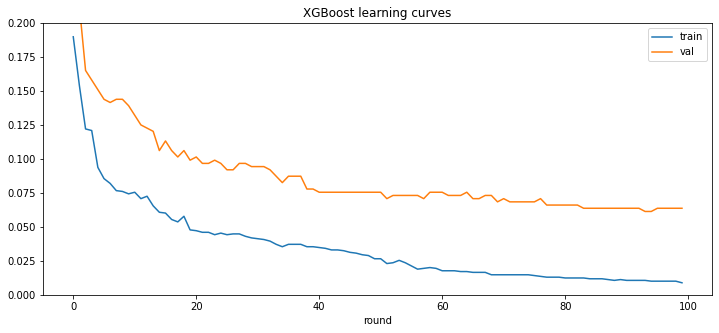

In [ ]:
evals_result = clf.evals_result()
train_errors = evals_result['validation_0']['merror']
validation_errors = evals_result['validation_1']['merror']
df = pd.DataFrame([train_errors, validation_errors]).T
df.columns = ['train', 'val']
df.index.name = 'round'
df.plot(title = 'XGBoost learning curves', ylim = (0,0.2), figsize = (12,5))

Validation error levels off at around .075 learning curve. Let's check the optimal max_depth next. 

In [ ]:
results = []
for max_depth in [3,6,9,12,15,30]:
  clf = xgb.XGBClassifier(max_depth = max_depth, n_estimators=20)
  clf = clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose = False)
  results.append(
      {
          'max_depth': max_depth, 
          'train_error': 1- accuracy_score(y_train, clf.predict(X_train)),
          'validation_error': 1-accuracy_score(y_val, clf.predict(X_val)),
          'test_error' : 1-accuracy_score(y_test, clf.predict(X_test))
      }
  )

In [ ]:
df_max_depth = pd.DataFrame(results).set_index('max_depth').sort_index()
df_max_depth

,train_error,validation_error,test_error
max_depth,,,
3,0.047759,0.099057,0.067925
6,0.012382,0.068396,0.049057
9,0.005896,0.058962,0.045283
12,0.004127,0.061321,0.045283
15,0.004127,0.063679,0.041509
30,0.002948,0.058962,0.039623


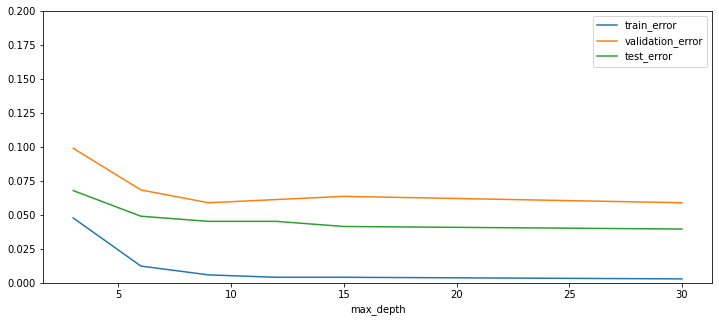

In [ ]:
df_max_depth.plot(ylim = (0,0.2), figsize = (12,5))

Optimal depth of tree levels off around 6. You'll notice that validation error actually increases as the max_depth increases beyond 10. This is attributable to an complex model that is overfitted to our training data. Let's check on the feature importances next. 

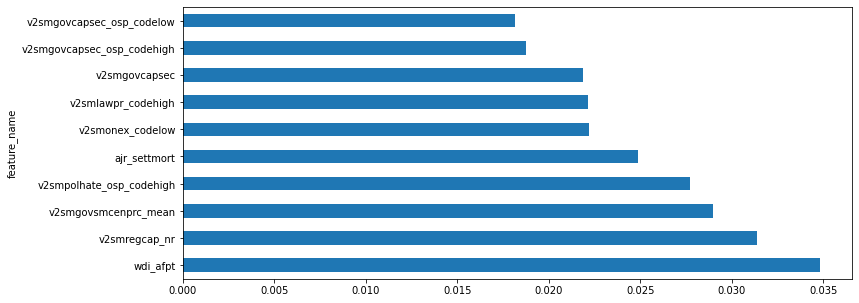

In [ ]:
type(clf.feature_importances_)
df = pd.DataFrame([X_train.columns, list(clf.feature_importances_)]).T
df.columns = ['feature_name', 'feature_score']
df.sort_values('feature_score', ascending=False, inplace = True)
df.set_index('feature_name', inplace = True)
df.iloc[:10].plot(kind = 'barh', legend = False, figsize = (12,5))

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test[:300])

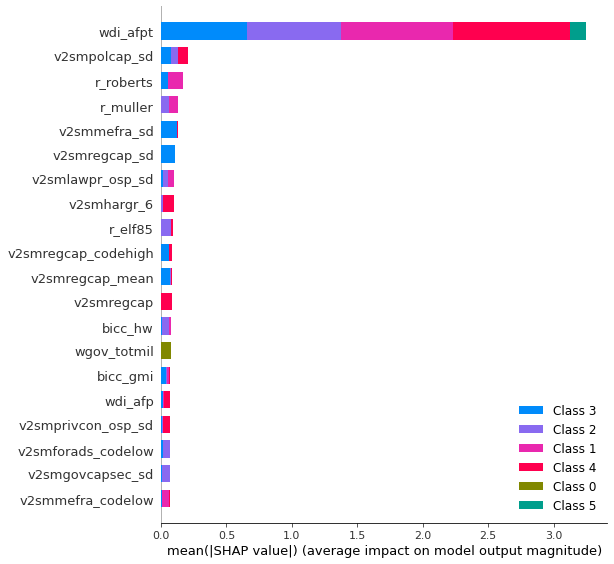

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Similarly to our Regression Problem, Armed forces personnel played a significant role in the output of our model. Please refer to the respective codebooks for other significant factors. 

In [ ]:
pred_clf = pred_df
pred_clf['labels']=clf.predict(pred_clf.iloc[:,4:-1])

In [ ]:
predictions = pred_clf[['country_name', 'year','COWcode','labels']]
mod_cinc = bin_df.groupby('country_name',as_index=True)['cinc'].apply(pd.Series.mode)
predictions = predictions.merge(mod_cinc, on = 'country_name')

#calculate the difference between predicted values and the average by country
predictions['Delta'] = abs(predictions.labels-predictions.cinc)
predictions.rename(columns = {'cinc':'Mode CINC'}, inplace = True)

In [ ]:
print('Misclassification Rate:{:.2f}'.format(1-len(predictions[predictions.Delta==0])/len(predictions)))
print(predictions.tail(10))

Misclassification Rate:0.33
    country_name  year  COWcode  labels  Mode CINC  Delta
618   Tajikistan  2019    702.0       2          2      0
619   Tajikistan  2020    702.0       1          2      1
620    Indonesia  2017    850.0       4          4      0
621    Indonesia  2018    850.0       4          4      0
622    Indonesia  2019    850.0       1          4      3
623    Indonesia  2020    850.0       1          4      3
624      Ecuador  2017    130.0       3          3      0
625      Ecuador  2018    130.0       3          3      0
626      Ecuador  2019    130.0       1          3      2
627      Ecuador  2020    130.0       1          3      2


The classification model misclassified the country 33% of the time when compared to the mode of classifiers by country. This can be explained in two possibilies: (1) The countries standard deviation is greater than the percentiles (can be easily checked), or (2) we are missing too much data for 2019 and 2020 (This seems to be the case as the majority of these dates are misclassified).

In [ ]:
stdev_df = bin_df.groupby('country_name', as_index = True)['cinc'].agg(np.std)
stdev_df

country_name
Afghanistan    0.242536
Albania        0.507300
Algeria        0.000000
Angola         0.242536
Argentina      0.000000
                 ...   
Venezuela      0.000000
Vietnam        0.000000
Yemen          0.000000
Zambia         0.000000
Zimbabwe       0.507300
Name: cinc, Length: 157, dtype: float64